## Convolutional Neural Networks - Hymenoptera Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms       
from torch.utils.data import DataLoader  
import os       
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm  
from Plot import plot_image_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c1017RegisterOperatorsD1Ev)
  Referenced from: '/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 🍳 Data Preparation

In [2]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.transform = transform
        self.classes = [folder_name for folder_name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder_name))]
        self.class_to_idx = {label: i for i, label in enumerate(self.classes)}
        print(f"Assigned labels: {self.class_to_idx}")
        # Let's make a list of tuples mapping each image path to the label
        self.image_paths = []
        for label in self.classes:
            cls_path = os.path.join(data_dir, label)
            label_img_paths = [(os.path.join(cls_path, img), self.class_to_idx[label]) for img in os.listdir(cls_path) \
                if not img.startswith('.')]
            self.image_paths.extend(label_img_paths)

    def __getitem__(self, index):
        img_path, label = self.image_paths[index]
        img = Image.open(img_path)
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.image_paths)

In [7]:

# Define mean and std for normalization
mean = (0.5, 0.5, 0.5)
std = (0.25, 0.25, 0.25)

# Define transforms for training and validation data separately
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create custom datasets
train_data = CustomDataset('data/Hymenoptera/train', transform=train_transform)
val_data = CustomDataset('data/Hymenoptera/val', transform=val_transform)

# Define batch size
batch_size = 16

# Loading the data in batches
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)

Assigned labels: {'bees': 0, 'ants': 1}
Assigned labels: {'bees': 0, 'ants': 1}


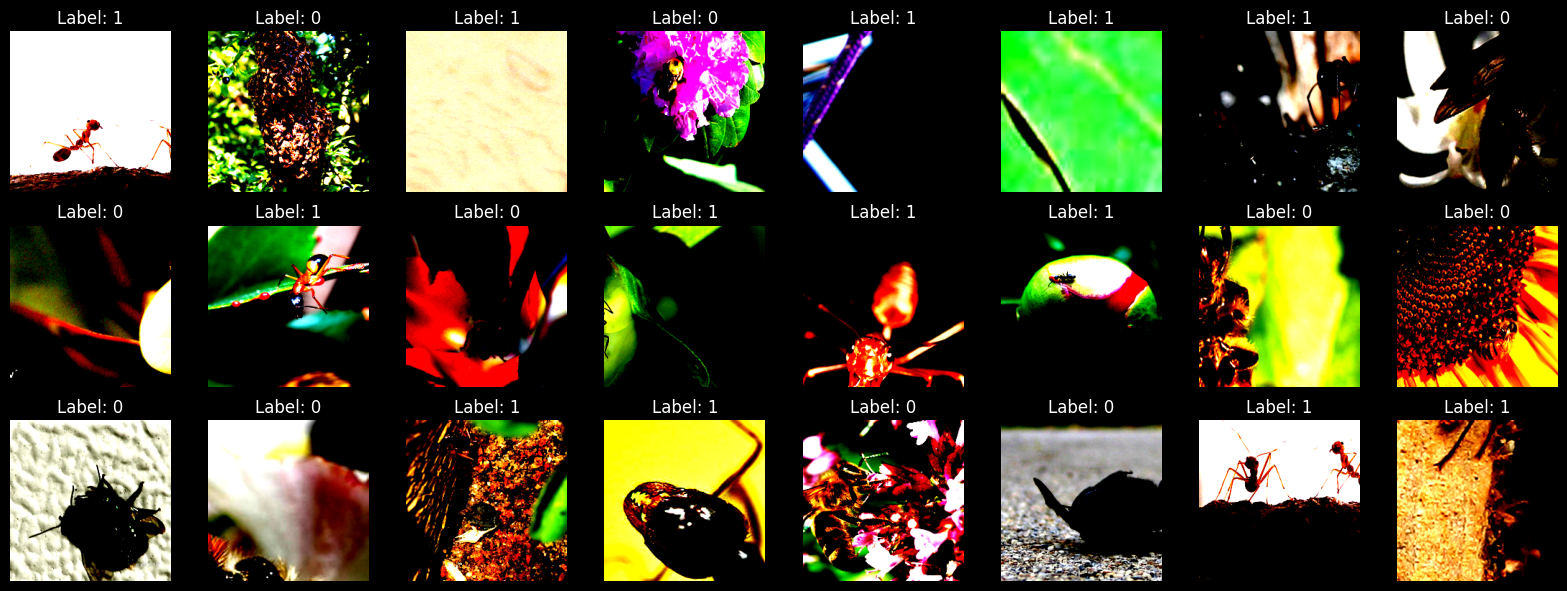

In [8]:
plot_image_grid(train_data)

## 🚢 Model Building

<img src="https://i.imgur.com/CdbdFDe.png">

A convolutional neural network is like an ordinary feedforward neural network except that:

- It does not flatten the input image immediately (i.e., unlike last example)

- It precedes the linear layers with convolutional + activation and pooling layers

  - A convolutional layer with $k$ filters applies $k*c$ convolutions on its input with $c$ channels, adds results from different channels then adds bias to produce $k$ results
  
    - The weights of the convolutional layer are the filter itself; it learns to use filters that extract meaningful features

  - A pooling layer reduces the spatial size of its input by taking the max or average (or...) of the values (channel-wise)
    - I.e., instead of multiplying and summing like convolution it gets the max or average under its window

    - Purpose of this is to summarize the input

- These layers make the final image like structure (i.e., feature map) easy to learn from
  - It's flattened and goes to the linear layers

In [9]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # The following layer will perform 16 convolutions each with three channels
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),    # [224, 224, 3] -> [224, 224, 16]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                                  # [224, 224, 16] -> [112, 112, 16]
            nn.Conv2d(16, 32, kernel_size=3, padding=1),                            # [112, 112, 16] -> [112, 112, 32]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                                  # [112, 112, 32] -> [56, 56, 32]
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## 💪 Model Training

In [10]:
num_batches = len(train_loader)
def train_model(model, criterion, optimizer, num_epochs=2):
    with tqdm(range(num_epochs), desc="Epochs") as epoch_bar:
        for epoch in epoch_bar:
            total_loss, num_correct = 0.0, 0
            
            for (xb, yb) in train_loader:
                # 0. Move to GPU
                xb = xb.to(device)
                yb = yb.to(device)

                # 1. Forward pass
                ŷb = model(xb)
                loss = criterion(ŷb, yb)

                # 2. Backward pass
                loss.backward()
                
                # 3. Optimization step
                optimizer.step()
                optimizer.zero_grad()

                # 4. Statistics:
                total_loss += loss.item() 
                ŷb = ŷb.argmax(dim=1)

                num_correct += torch.sum(ŷb == yb.data).item()

            epoch_loss = total_loss / num_batches                
            epoch_acc = num_correct / (num_batches * train_loader.batch_size)
            epoch_bar.set_postfix(loss=epoch_loss, accuracy = epoch_acc)
    return model

## 🕵️ Evaluation

In [11]:
def validate_model(model):
    model.eval()
    with torch.no_grad():
        num_correct = 0
        for xb, yb in val_loader:
            # 0. Move to GPU
            xb, yb = xb.to(device), yb.to(device)
            # 1. Forward pass
            ŷb = model(xb)                       # (batch_size, num_classes)
            # 2. Statistics 
            ŷb = ŷb.argmax(1)      
            num_correct += (ŷb == yb).sum().item()

        acc = 100.0 * num_correct / len(val_data)
        print(f'Accuracy: {round(acc,3)} %')

### 🔮 Initiate Model, Criterion and Optimizer

In [12]:
# Initialize the model
model = SimpleCNN(2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=100352, out_features=2, bias=True)
)

### 💪🕵️ Train and Evaluate

In [13]:
model = train_model(model, criterion, optimizer, num_epochs=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
validate_model(model)

Accuracy: 62.745 %


### 💻 Deployment

Text(0.5, 1.0, 'Prediction: ants')

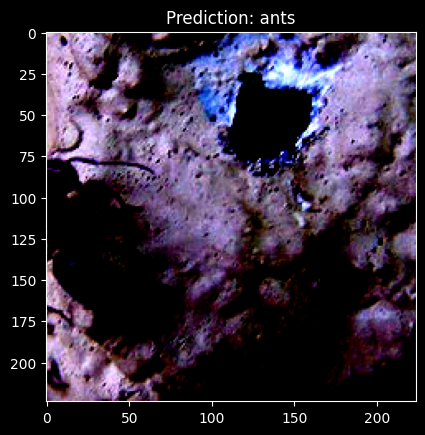

In [21]:
model = model.eval()
# load and show some random image
rand_num = torch.randint(0, 100, (1,)).item()
rand_val_img, _ = val_data[rand_num]
plt.imshow(torch.clip(rand_val_img.permute(1, 2, 0), 0, 1))

# get its corresponding prediction and show it
idx_to_class = {v: k for k, v in val_data.class_to_idx.items()}
prediction = model(rand_val_img.to(device).unsqueeze(0)).argmax(dim=1).item()
plt.title(f'Prediction: {idx_to_class[prediction]}')

#### 🤔 Can we do better with less effort?

<img src="https://i.imgur.com/P4Tz8nA.png" width="1300">

Resnet-18 is a deep convolutional network which 18 layers. Back then deep networks were hard to train because in backpropagation they imply more multiplications which causes vanishing gradients. They were able to overcome this issue using residual (i.e., skip) connections.

In [22]:
from torchvision.models import resnet18

It won 1st place on the annual ILSVRC 2015 classification competition (1000 classes).

- Although it was trained on a different task than ours we can use it as follows:

  - Freeze all layers except the last one (remove it and add a new appropriate one for the task)

  - Train only the last layer.

- The idea is that earlier layers learn low-level (or basic features) which are common among all tasks. 

    - E.g., learning how to pronounce basic letters in linguistics would help learn more languages as well

    - This is called transfer learning

In [26]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class ModifiedResNet(nn.Module):
    def __init__(self, num_outputs, freeze=False):
        super(ModifiedResNet, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_inputs = self.model.fc.in_features
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Linear(num_inputs, num_outputs)      # The final layer is called fc in the class
    
    def forward(self, x):
        return self.model(x)


resnet_model = ModifiedResNet(num_outputs=2, freeze=True)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

In [27]:
train_model(resnet_model, criterion, optimizer, num_epochs=3)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

ModifiedResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [28]:
validate_model(resnet_model)

Accuracy: 86.275 %


Text(0.5, 1.0, 'Prediction: bees')

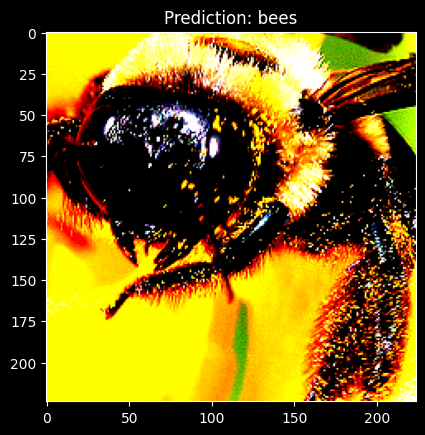

In [70]:
model = resnet_model.eval()
# load and show some random image
rand_num = torch.randint(0, 100, (1,)).item()
rand_val_img, _ = val_data[rand_num]
plt.imshow(torch.clip(rand_val_img.permute(1, 2, 0), 0, 1))

# get its corresponding prediction and show it
idx_to_class = {v: k for k, v in val_data.class_to_idx.items()}
prediction = resnet_model(rand_val_img.to(device).unsqueeze(0)).argmax(dim=1).item()
plt.title(f'Prediction: {idx_to_class[prediction]}')

<img src="https://i.imgur.com/LgCtYGd.png">